In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib as plt
import itertools as it
from analysis_utils import *

In [2]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

# Setup

In [3]:
EXPERIMENT = 7

os.makedirs(f'stats/{EXPERIMENT}', exist_ok=True)
def write_tex(name, tex):
    file = f"stats/{EXPERIMENT}/{name}.tex"
    with open(file, "w+") as f:
        f.write(str(tex) + r"\unskip")
    print(f'wrote "{tex}" to "{file}"')

data = get_data(EXPERIMENT)
pdf = data['participants'].set_index('pid').copy()
pdf.query('completed', inplace=True)
full_pdf = pdf.copy()
mdf = data['trials'].set_index('pid').copy()
mdf.trial_time /= 1000
mdf['clicked'] = mdf.n_clicks > 0

## Demographics

In [4]:
pids = list(pdf.index.unique())
sdf = data['survey'].query('pid == @pids').copy()
if not isinstance(sdf.responses.iloc[0], dict):
    sdf = sdf.loc[~sdf.responses.isna()]
    sdf.responses = sdf.responses.apply(ast.literal_eval)

if EXPERIMENT == 3:
    demo = sdf.loc[sdf.responses.apply(len) == 3].set_index('pid').responses
    age = demo.apply(get('Q1'))
    gender = demo.apply(get('Q2'))
else:
    demo = sdf.loc[sdf.responses.apply(len) == 2].set_index('pid').responses
    age = demo.apply(get('Q0'))
    gender = demo.apply(get('Q1'))
    
gender = gender.str.lower()
age = age.apply(excepts(ValueError, int, lambda _: None))

write_tex('mean-age', f'{age.mean():.2f}')
write_tex('min-age', str(age.min()))
write_tex('max-age', str(age.max()))

regularize = {
    'man': 'male',
    'woman': 'female',
    'f': 'female',
    'm': 'male',
}
gender = gender.apply(lambda x: regularize.get(x.strip(), x))
write_tex("N-female", str(gender.value_counts()['female']))

write_tex("N-total", f"${len(pdf)}$")
for fb, n in pdf.train_height.value_counts().items():
    write_tex(f"N-{fb}", f"${n}$")

wrote "35.02" to "stats/7/mean-age.tex"
wrote "20" to "stats/7/min-age.tex"
wrote "67" to "stats/7/max-age.tex"
wrote "62" to "stats/7/N-female.tex"
wrote "$156$" to "stats/7/N-total.tex"
wrote "$53$" to "stats/7/N-1.tex"
wrote "$52$" to "stats/7/N-2.tex"
wrote "$51$" to "stats/7/N-3.tex"


In [5]:
if EXPERIMENT == 3:
    dropped = pdf.query('not completed').feedback.value_counts()
    rate = dropped / pdf.feedback.value_counts()
    for fb in fb_order:
        write_tex(f'N-drop-{fb}', dropped[fb])
        write_tex(f'drop-rate-{fb}', f'${rate[fb]*100:.1f}\%$')
    write_tex('return-rate', f'${pdf.completed.mean()*100:.1f}\%$')
    write_tex('return-N', f'${pdf.completed.sum()}$')
    pdf.query('completed', inplace=True)
    
pd.Series(pdf.index).to_csv(f'pids/{EXPERIMENT}.csv', index=False, header=False)

In [6]:
completed = list(pdf.index)
mdf.reset_index(inplace=True)
mdf.query('pid == @completed', inplace=True)
mdf.set_index('pid', inplace=True)

# pdf.train_height = pd.Categorical(pdf.train_height, [1,2,3], ordered=True)    
mdf['train_height'] = pdf.train_height
block_mean = mdf.groupby(['block', 'pid']).score.mean()
for b in ['training', 'test']:
    pdf[b] = block_mean[b]

    
assert set(mdf.index.unique()) == set(pdf.index.unique())

In [7]:

def get_leaves(train_height):
    branch = {
        1: "3",
        2: "3-1",
        3: "3-1-2",
    }[train_height]
    fn = f"structures/{branch}.json"
    with open(fn) as f:
        graph = json.load(f)['graph']
        return set(int(k) for k, v in graph.items() if not v)
    

all_leaves = { th: get_leaves(th) for th in [1,2,3]}
all_leaves['test'] = {5, 6, 7, 9, 10, 11, 16, 17, 18, 20, 21, 22, 27, 28, 29, 31, 32, 33}

def clicked_leaf_first(row):
    if not row.clicks:
        return False
    first = row.clicks[0]
    leaves = all_leaves['test' if row.block == 'test' else row.train_height]
    return first in leaves

mdf['backward'] = mdf.apply(clicked_leaf_first, axis=1)
pdf['backward'] = mdf.query('block == "test"').groupby('pid').backward.mean()

## Setup Plotting 

In [8]:
figure = Figures(path=f'figs/{EXPERIMENT}', formats=['pdf', 'png']).plot

sns.set_style('whitegrid')
blue, orange, green, _, purple = sns.color_palette('tab10')[:5]
gray = (0.5,)*3
red = (1, 0.3, 0.4)
yellow = (1, 0.9, 0.4)
palette = {
    'none': gray,
    'action': blue,
    'meta': orange,
    'info_only': red,
    'reward_only': yellow,
    'both': orange,
}

palette = {
    'none': gray,
    'action': blue,
    'meta': orange,
    'info_only': red,
    'reward_only': yellow,
    'both': orange,
    1: purple,
    2: green,
    3: orange
}

nice_names = {
    'meta': 'Metacognitive',
    'action': 'Action',
    'none': 'None',
    'feedback': 'Feedback',
    'info_only': 'Information\nOnly',
    'reward_only': 'Reward\nOnly',
    'both': 'Information &\nReinforcement',
    'score': 'Average Score',
    'backward': 'Proportion Planning Backward'
}

def reformat_labels(ax=None):
    ax = ax or plt.gca()
    labels = [t.get_text() for t in ax.get_xticklabels()]
    new_labels = [nice_names.get(lab, lab) for lab in labels]
    ax.set_xticklabels(new_labels)
    
def reformat_legend(ax=None):
    if ax is None:
        ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    print([nice_names.get(l, l).replace('\n', ' ') for l in labels])
    ax.legend(handles=handles, labels=[nice_names.get(l, l).replace('\n', ' ') 
                                       for l in labels])
    
def plot_block_changes():
    block_changes = mdf.loc[1].block.apply(Labeler()).diff().reset_index().query('block == 1').index
    for t in block_changes:
        plt.axvline(t-0.5, c='k', ls='--')

from datetime import datetime
# os.makedirs(f'stats/{EXPERIMENT}/', exist_ok=True)
def result_file(name, ext='tex'):
    file = f'stats/{EXPERIMENT}-{name}.{ext}'
#     with open(file, 'w+') as f:
#         timestamp = datetime.now().strftime('Created on %m/%d/%y at %H:%M:%S\n\n')
#         f.write(timestamp)
    return file

# Bootstrap utils

In [19]:
def ci(x, interval=95):
    a = (1 - (interval / 100)) / 2
    return np.quantile(x, [a, 1-a])


def boot_mean_ci(x, interval=95, n=10000):
    x = pd.Series(x)
    means = [x.sample(frac=1, replace=True).mean() for _ in range(n)]
    return ci(means, interval)

def make_permutation_test(values, name=None, n=10000):
    if name is None:
        name = values.name

    def null_mean_diff_samples(c1, c2):
        r = []
        x = values.copy()
        for i in range(n):
            np.random.shuffle(x.values)
            r.append(x.loc[c1].mean() - x.loc[c2].mean())
        return np.array(r)

    #         x = values.sample(n=n_fb[c1], replace=True)
    #         y = values.sample(n=n_fb[c2], replace=True)
    #         r.append(x.mean() - y.mean())

    def report(c1, c2):
        actual_diff = values.loc[c1].mean() - values.loc[c2].mean()
        null_diff = null_mean_diff_samples(c1, c2)
    #     p = (1 + np.sum(abs(null_diff) >= abs(actual_diff))) / (n+1)
        p = np.mean(abs(null_diff) >= abs(actual_diff))
        write_tex(f'{name}-permutation-{c1}-{c2}', f'${pval(p)}$')

    return report

def report_means_ci(g, name, units='',  **kws):
    if name is None:
        name = values.name
    for k, d in g:
        x = d.mean()
        a, b = boot_mean_ci(d, **kws)
        tex = rf'${x:.2f}$ {units}; 95\% CI: [${a:.2f}$, ${b:.2f}$]'
        write_tex(f'{name}-mean-{k}', tex)

# Test score

figs/7/test.pdf
figs/7/test.png


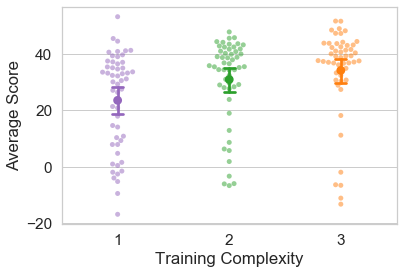

In [231]:
@figure()
def plot_test():
    if EXPERIMENT == 4:
        plt.figure(figsize=(12,4))

    sns.swarmplot('train_height', 'test', data=pdf, palette=palette, alpha=0.5)
    sns.pointplot('train_height', 'test', data=pdf, palette=palette, 
                  scale=1, capsize=0.1, markers='o')
    plt.xlabel('Training Complexity')
    plt.ylabel(nice_names['score'])
    test = 'Test' if EXPERIMENT == 1 else 'Transfer'
    reformat_labels()
    

## Kruskal

In [241]:
rdf = pdf[['test', 'train_height']].copy()
rdf.train_height = 'T' + rdf.train_height.astype(str)
rdf.train_height = rdf.train_height.astype(str)

In [244]:
%%R -i rdf -o out
out = kruskal.test(test ~ factor(train_height), data=rdf)

In [245]:
out = dict(out.items())
df = out["parameter"][0]
p = pval(out["p.value"][0])
stat = out["statistic"][0]
write_tex('score-kruskal', rf'$\chi^2({df}) = {stat:.3f}, {p}$')
# p = pvalue(out

wrote "$\chi^2(2) = 16.658, p < .001$" to "stats/7/score-kruskal.tex"


## Bootstrapping

In [21]:
report_means_ci(pdf.groupby('train_height').test, 'test', 'points/trial')

wrote "$23.53$ points/trial; 95\% CI: [$18.87$, $28.06$]" to "stats/7/test-mean-1.tex"
wrote "$30.94$ points/trial; 95\% CI: [$26.57$, $34.79$]" to "stats/7/test-mean-2.tex"
wrote "$34.17$ points/trial; 95\% CI: [$29.70$, $38.18$]" to "stats/7/test-mean-3.tex"


In [247]:
report = make_permutation_test(pdf.set_index('train_height').test)
report(2, 1)
report(3, 1)
report(3, 2)

wrote "$p = .023$" to "stats/7/test-permutation-2-1.tex"
wrote "$p = .001$" to "stats/7/test-permutation-3-1.tex"
wrote "$p = .319$" to "stats/7/test-permutation-3-2.tex"


In [22]:
report_means_ci(d.groupby('train_height'), 'early-test', 'points/trial')

wrote "$0.25$ points/trial; 95\% CI: [$0.17$, $0.33$]" to "stats/7/early-test-mean-1.tex"
wrote "$0.62$ points/trial; 95\% CI: [$0.50$, $0.72$]" to "stats/7/early-test-mean-2.tex"
wrote "$0.81$ points/trial; 95\% CI: [$0.71$, $0.90$]" to "stats/7/early-test-mean-3.tex"


In [23]:
d = mdf.query('10 <= trial_index < 15')\
    .groupby('pid')[['score', 'train_height']].mean()\
    .set_index('train_height').score

report = make_permutation_test(d, name='test-early')
report(2, 1)
report(3, 1)
report(3, 2)

wrote "$p < .001$" to "stats/7/test-early-permutation-2-1.tex"
wrote "$p < .001$" to "stats/7/test-early-permutation-3-1.tex"
wrote "$p = .413$" to "stats/7/test-early-permutation-3-2.tex"


# Learning curves

['train_height', '1', '2', '3']
figs/7/learning_curve_score.pdf
figs/7/learning_curve_score.png


<function analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

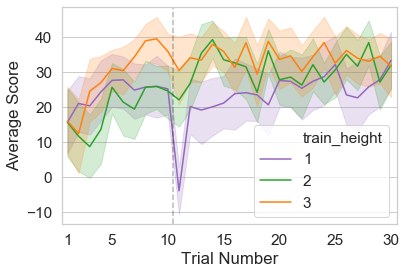

In [24]:
def learning_curve(var):
    df = mdf.copy()
    df.trial_index += 1
    sns.lineplot('trial_index', var, hue='train_height', 
                 data=df, palette=palette)
    plt.ylabel(nice_names[var])
    plt.xlabel('Trial Number')
    plt.gca().grid(axis='x')
    split = mdf.query('block == "training"').trial_index.max()
    plt.axvline(split+1.5, c='k', ls='--', alpha=0.3)
    plt.xticks([1, *range(5, 31, 5)])
    plt.xlim(df.trial_index.min()-0.5, df.trial_index.max()+0.5)
    reformat_legend()
    
figure(var='score')(learning_curve)

['train_height', '1', '2', '3']
figs/7/learning_curve_backward.pdf
figs/7/learning_curve_backward.png


<function analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

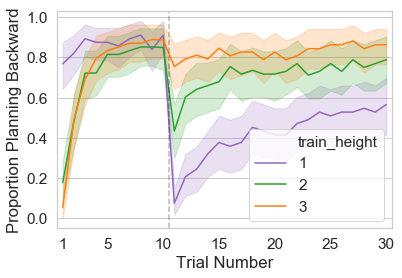

In [101]:
figure(var='backward')(learning_curve)

# Process

## Summary in test block

In [270]:
def report_ratio(df, key, name=None):
    if name is None:
        name = key.replace('_', '-')
    X = df.groupby(['train_height', key]).apply(len)
    rate = 100 * df.groupby('train_height')[key].mean()

    for c in [1,2,3]:
        r = rate[c]
        write_tex(f'{name}-{c}-percent', f"${r:.1f}$\%")


report_ratio(mdf.query('block == "test"').copy(), 'backward')

early_test = mdf.query('10 <= trial_index < 15')\
    .groupby('pid')[['backward', 'train_height']].mean()\
    .set_index('train_height')

report_ratio(early_test, 'backward', name='backward-early')

wrote "$41.9$\%" to "stats/7/backward-1-percent.tex"
wrote "$71.6$\%" to "stats/7/backward-2-percent.tex"
wrote "$83.0$\%" to "stats/7/backward-3-percent.tex"
wrote "$24.5$\%" to "stats/7/backward-early-1-percent.tex"
wrote "$61.5$\%" to "stats/7/backward-early-2-percent.tex"
wrote "$80.8$\%" to "stats/7/backward-early-3-percent.tex"


## Kruskal

In [163]:
rdf = pdf[['backward', 'train_height']].copy()
rdf.train_height = 'T' + rdf.train_height.astype(str)

In [174]:
%%R -i rdf -o out
out = pairwise.t.test(rdf$backward, rdf$train_height)

In [103]:
%%R -i rdf -o out
out = kruskal.test(backward ~ factor(train_height), data=rdf)


	Kruskal-Wallis rank sum test

data:  backward by factor(train_height)
Kruskal-Wallis chi-squared = 44.036, df = 2, p-value = 2.74e-10



In [105]:
out = dict(out.items())
df = out["parameter"][0]
p = pval(out["p.value"][0])
stat = out["statistic"][0]
write_tex('backward-kruskal', rf'$\chi^2({df}) = {stat:.3f}, {p}$')
# p = pvalue(out

wrote "$\chi^2(2) = 44.036, p < .001$" to "stats/7/backward-kruskal.tex"


## t-tests

In [202]:
from scipy.stats import ttest_ind
# d = pdf.set_index('train_height').backward
d = mdf.query('10 <= trial_index < 15')\
    .groupby('pid')[['backward', 'train_height']].mean()\
    .set_index('train_height').backward

In [203]:
def ttest(c1, c2):
    x, y = d[c1], d[c2]
    out = %R -i x -i y t.test(x, y)
    out = dict(out.items())
    df = out['parameter'][0]
    p = out['p.value'][0]
    stat = out['statistic'][0]
    write_tex(f'backward-ttest-{c1}v{c2}', rf'$t({df:.1f}) = {stat:.3f} {pval(p)}$')
    
ttest(2, 1)
ttest(3, 1)
ttest(3, 2)

wrote "$t(96.5) = 5.277 p < .001$" to "stats/7/backward-ttest-2v1.tex"
wrote "$t(99.1) = 8.524 p < .001$" to "stats/7/backward-ttest-3v1.tex"
wrote "$t(100.2) = 2.576 p = .011$" to "stats/7/backward-ttest-3v2.tex"


## Bootstrapping

In [268]:
report = make_permutation_test(pdf.set_index('train_height').backward)
report(2, 1)
report(3, 1)
report(3, 2)

In [20]:
d = mdf.query('10 <= trial_index < 15')\
    .groupby('pid')[['backward', 'train_height']].mean()\
    .set_index('train_height').backward

report = make_permutation_test(d, name='backward-early')
report(2, 1)
report(3, 1)
report(3, 2)

wrote "$p < .001$" to "stats/7/backward-early-permutation-2-1.tex"
wrote "$p < .001$" to "stats/7/backward-early-permutation-3-1.tex"
wrote "$p = .021$" to "stats/7/backward-early-permutation-3-2.tex"


## Mediation

In [112]:
rdf = mdf.query('block == "test"').copy().rename(columns={'information': 'info'})
# rdf['feedback'] = (rdf.feedback != 'none').astype(int)


factors = [f'T{c}' for c in (1,2,3)]
fb = rdf.pop('train_height')
for c in (1,2,3):
    rdf[f'T{c}'] = (fb == c).astype(int)

rdf['clicked'] = rdf.clicked.astype(int)
rdf = rdf[[*factors, 'backward', 'clicked', 'n_clicks', 'score', 'trial_index', 'stim_i']].reset_index()
rdf.backward.fillna(0, inplace=True)
# rdf.trial_index = rdf.trial_index.astype(float)
# rdf.query('action == 0', inplace=True)
rdf = rdf.groupby('pid').mean()
rdf.trial_index -= rdf.trial_index.min()

In [113]:
%%R -i rdf -o score
fit = lm(score ~ backward, data=rdf)
score = summary(fit)
score


Call:
lm(formula = score ~ backward, data = rdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.325  -5.671   0.054   4.384  32.116 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    9.584      1.638   5.849 2.86e-08 ***
backward      30.488      2.125  14.345  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.9 on 154 degrees of freedom
Multiple R-squared:  0.572,	Adjusted R-squared:  0.5692 
F-statistic: 205.8 on 1 and 154 DF,  p-value: < 2.2e-16



In [114]:
score = dict(score.items())
df = score['df'][1]
est, std, t, p = score['coefficients'][1]
write_tex(f'score-backward', f'${est:.3f}$')
write_tex(f'score-backward-test', f'$t({df}) = {t:.3f}$, ${pval(p)}$')

wrote "$30.488$" to "stats/7/score-backward.tex"
wrote "$t(154) = 14.345$, $p < .001$" to "stats/7/score-backward-test.tex"


In [120]:
%%R -i rdf -o back
back_fit = lm(backward ~ T2 + T3, data=rdf)
back = summary(back_fit)
back


Call:
lm(formula = backward ~ T2 + T3, data = rdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8304 -0.3689  0.1696  0.2336  0.5811 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.41887    0.05157   8.122 1.42e-13 ***
T2           0.29748    0.07328   4.059 7.82e-05 ***
T3           0.41152    0.07364   5.588 1.02e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3754 on 153 degrees of freedom
Multiple R-squared:  0.1795,	Adjusted R-squared:  0.1688 
F-statistic: 16.74 on 2 and 153 DF,  p-value: 2.665e-07



In [23]:
back = dict(back.items())
df = back['df'][1]
for i, name in enumerate(fb_order[1:], start=1):
    est, std, t, p = back['coefficients'][i]
    write_tex(f'backward-lm-{name}', f'$t({df}) = {t:.3f}$, ${pval(p)}$')

NameError: name 'back' is not defined

In [ ]:
names = {
    'acme': 'd0',
    'ade': 'z0',
    'total': 'tau',
    'prop': 'n0',
}
med = dict(med_out.items())

for k, v in names.items():
    est = med[v + ('.coef' if v == 'tau' else '')][0]
    lo, hi = med[v+'.ci']
    p = med[v+'.p'][0]
    write_tex(f'mediation-{k}', f'{est:.3f}')
    write_tex(f'mediation-{k}-ci', f'95\% CI: [{lo:.3f}, {hi:.3f}], ${pval(p)}$')

In [ ]:
print("Success!")